<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/Week_4/SanneAartsML2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install tensorflow==2.3.0
# %pip install gym==0.22
# %pip install keras
%pip install keras-rl2==1.0.4

Note: you may need to restart the kernel to use updated packages.


In [63]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential, load_model
from keras.layers import Dense,  Flatten
from keras.optimizers import Adam, RMSprop
import os


#### Bellman Equation

\begin{equation}
Q_{new}(s, a)=Q(s,a)+\alpha \left[ r(s,a)+ \gamma * max_{a'}(Q'(s',a'))-Q(s,a)\right] \hspace{1em}
\begin{array}{rl}
Q_{new}:& \text{New Q value}\\
Q:& \text{Current Q value}\\
s:& \text{State}\\
a:& \text{Action}\\
\alpha:& \text{Learning Rate}\\
r:& \text{reward}\\
\gamma:& \text{Discount rate}\\
max(Q'(s',a')):& \text{Maximum expected future reward}\\
\end{array} 
\tag{1}
\end{equation}
#### Loss function

\begin{equation}
L=\frac{1}{2}\left[r+\gamma max_{a'}(Q'(s',a'))-Q(s,a) \right]^2 
\tag{2}
\end{equation}

In [100]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.env = gym.make("CartPole-v1")
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)

        self.gamma = 0.75
        self.exploration_rate = 1.0
        self.exploration_rate_decay = 0.995
        self.exploration_rate_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 60
        self.episodes = 400
        
        self.model = self.build_model()
        self.target_update_freq = 100
        self.target_model = self.build_model()
        self.update_target_model()
        
    def build_model(self):
        # Building Network
        # Create a Sequential model using keras
        model = Sequential()
        #Input - 4 different states 
        model.add(Dense(32, activation='relu', input_shape=(self.state_size,)))
        # model.add(Flatten(input_shape=(1,self.state_size)))
        model.add(Dense(32, activation='relu'))
        # Output - one node for each possible action, the one with the 
        # highest output value will be be returned as action
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # Greedy Epsilon policy, a random number between 0 and 1 is selected, if the number is smaller
        # than the exploration rate,a random action is selected from the available actions
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        # otherwise the action with the highest predicted Q-value is selected 
        # state is passed into the predict method to get the predicted Q value for
        # all possible actions (here, to go left or right)
        act_values = self.model.predict(state)
        # since we get two outputs, we want to select the action corresponding to the highest value
        return np.argmax(act_values[0])
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            q_update = reward
            if not done:
                q_update = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            q_value = self.model.predict(state)
            q_value[0][action] = q_update
            self.model.fit(state, q_value, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_rate_min:
            self.exploration_rate *= self.exploration_rate_decay
    
    def update_target_model(self):
            self.target_model.set_weights(self.model.get_weights())
    
    def save(self):
             self.model.save_weights('dqn_weights.h5f', overwrite=True)
        # self.model.save_weights(name)
    
    def test(self,test_episodes = 100):
        env_test = gym.make('CartPole-v1')

        # Load the saved model weights
        model = Sequential([
            Dense(32, activation='relu', input_dim=env_test.observation_space.shape[0]),
            Dense(32, activation='relu'),
            Dense(env_test.action_space.n, activation=None)
        ])
        model.load_weights('dqn_weights.h5f')

        # Set the epsilon value to zero for testing
        explorationrate  = 0.05

        # Run the test loop for 10 episodes
        test_episodes = 100
        test_rewards = []
        for i in range(test_episodes):
            state = env_test.reset()
            done = False
            ep_reward = 0
            while not done:
                # Use the learned policy to select actions
                q_values = model.predict(np.array([state]))[0]
                action = np.argmax(q_values)
                # Take the action and observe the new state and reward
                state, reward, done, _ = env_test.step(action)
                # Update the episode reward
                ep_reward += reward
            # Append the episode reward to the list of test rewards
            test_rewards.append(ep_reward)

        # Print the average reward obtained over all test episodes
        plt.plot(range(test_episodes), test_rewards)
        plt.axhline(sum(test_rewards)/len(test_rewards))
    



c:\Users\Sanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\Sanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


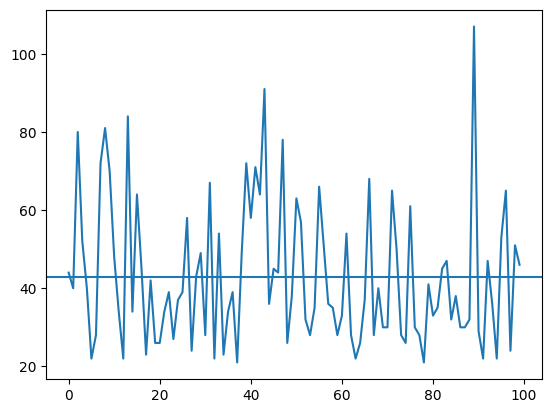

In [101]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size,action_size)
# agent.save("weights2.h5f")
agent.test()

In [67]:
def cartpole():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size,action_size)
    n_episodes = agent.n_episodes
    episode_rewards = deque(maxlen=300)
    runsteplog = []
    for episode in range(n_episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        steps = 0
        totalreward = 0
        done = False
        while steps < 500:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else - reward
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            steps += 1
            state = next_state
            totalreward += reward
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}".format(episode, n_episodes, totalreward, agent.exploration_rate))
                break
        runsteplog.append(steps)
        episode_rewards.append(totalreward)
        agent.replay()
        

    env.close()

    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))
    
    agent.save("weights")

c:\Users\Sanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


episode: 0/400, score: 22.0, e: 1.0
episode: 1/400, score: 22.0, e: 1.0
episode: 2/400, score: 42.0, e: 1.0


c:\Users\Sanne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode: 3/400, score: 13.0, e: 0.99
episode: 4/400, score: 13.0, e: 0.99
episode: 5/400, score: 10.0, e: 0.99
episode: 6/400, score: 10.0, e: 0.98
episode: 7/400, score: 13.0, e: 0.98
episode: 8/400, score: 14.0, e: 0.97
episode: 9/400, score: 10.0, e: 0.97
episode: 10/400, score: 36.0, e: 0.96
episode: 11/400, score: 23.0, e: 0.96
episode: 12/400, score: 15.0, e: 0.95
episode: 13/400, score: 14.0, e: 0.95
episode: 14/400, score: 28.0, e: 0.94
episode: 15/400, score: 71.0, e: 0.94
episode: 16/400, score: 17.0, e: 0.93
episode: 17/400, score: 16.0, e: 0.93
episode: 18/400, score: 33.0, e: 0.92
episode: 19/400, score: 22.0, e: 0.92
episode: 20/400, score: 10.0, e: 0.91
episode: 21/400, score: 32.0, e: 0.91
episode: 22/400, score: 12.0, e: 0.9
episode: 23/400, score: 17.0, e: 0.9
episode: 24/400, score: 10.0, e: 0.9
episode: 25/400, score: 38.0, e: 0.89
episode: 26/400, score: 21.0, e: 0.89
episode: 27/400, score: 12.0, e: 0.88
episode: 28/400, score: 27.0, e: 0.88
episode: 29/400, score

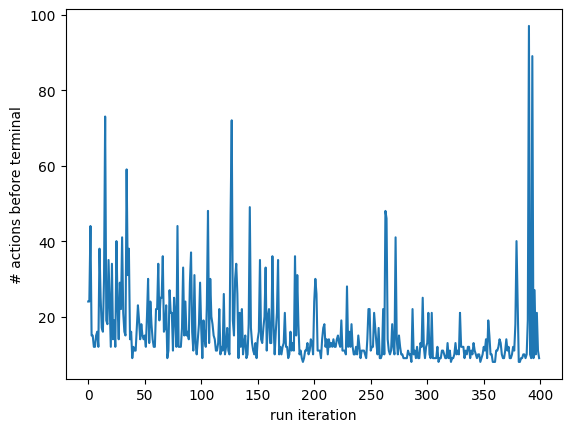

In [60]:
cartpole()

In [10]:
class cartpole:
    def __init__(self):
        self.n_episodes = 300
        self.max_steps_per_episode = 5000
        self.batch_size = 1
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.agent = DQNAgent(self.state_size,self.action_size)
        self.rewards = [self.runEpisode() for _ in range(self.n_episodes)]
    
    def runEpisode(self):
        episode_rewards = 0   
        state = self.env.reset()
        # the Keras neural network is expecting a row vector
        # so we turn the column vector into a row vector
        state = np.reshape(state, [1,self.state_size])
        # for _ in range(self.max_steps_per_episode):
        done = False
        while not done:
            # passing the state into the act method of the agent, this returns
            # a 0 (left) or 1 (right)
            action = self.agent.act(state)
            # we still need to apply it to the environment, which will return the 
            # next_state, the current reward and an update to the boolean that 
            # represents the state of the game, along with some other irrelevant data that we dont store
            next_state, reward, done, _ = self.env.step(action)
            # If the run was not the last of the episode the model is rewarded, ie. a positive reward
            # otherwise we subtract the reward, this disincentivises terminating the episode early
            reward = reward if not done else - reward
            episode_rewards += reward
            # We once again have to reshape the input 
            next_state = np.reshape(next_state, [1,self.state_size])
            # We store the current state, the action taken, the reward it led to, the next state and the boolean done
            # in the memory of the agent
            self.agent.remember(state, action, reward, next_state, done)
            # prepare the next iteration, corresponding to time+1 by setting the state equal to the next state
            # episode_rewards.append(reward)
            state = next_state
            # print summary
            # if done:
            #     # epsilons.append(agent.exploration_rate)
            #     # score.append(reward)
            #     # print(f"episode: {episode}/{n_episodes}, time: {time}, e: {agent.exploration_rate}")
            #     # log.append(time)
            #     # log +=[time]

            #     break
            # increment our time counter
        # to increase the training speed of each episode, we can decrease the frequeny with which we call the train function,
        # note that because of this, it may take more episodes to solve    
        if len(self.agent.memory) > self.batch_size:
            self.agent.train(self.batch_size) 
        return episode_rewards    
        # Every 50 episodes, store the parameters
        # if episode % 50 == 0:
        #     agent.save(output_dir + "weights_"
        #             + f"{episode}" + ".hdf5")
    def plotting(self):
        print(len(self.rewards))
    # plt.plot(agent.rewards)
    # # print(agent.memory[2])
    # env.close()

In [11]:
cp = cartpole()
cp.plotting()

Train on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 0.4905
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.5724
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 0.5299
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 0.4950
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.5867
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.5388
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.4950
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.4879
Train on 1 samples
1/1 [==============================] - 0s 2ms/sample - loss: 0.4742
Train on 1 samples
1/1 [==============================] - 0s 3ms/sample - loss: 0.4967
Train on 1 samples
1/1 [==============================] - 0s 1ms/sample - loss: 0.6174
Train on 1 samples
1/1 [=================

## The cartPole
### Action space
<ul>
<li>push left - 0</li>
<li>push right - 1</li>
</ul>

### Observation space
|num|Observation|Values|Episode terminates for:|
|-|-|-|-|
|0|Cart position|$\pm$ 4.8|$\lvert x \rvert > 2.4$|
|1|Cart Velocity|$\pm \infty$||
|2|Pole Angle|$\pm$ 24 $^ \circ$|$\lvert \theta \rvert > 12 ^\circ $|
|3|Pole Angular Velocity|$\pm\infty$||


## Agent

$$loss=\left(r+\gamma max \hat{Q}(s,a')-Q(s,a\right)^2$$